In [1]:
import json
from urllib import parse
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import colors, cm, pyplot as plt
import urllib.request
from PIL import Image

In [2]:
PIXELS_X = 224
PIXELS_Y = 224

In [3]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [4]:
# specify the precursor cuboid to visualise
RUN_NAME = '190719_Hela_Ecoli_1to1_01'
PRECURSOR_ID = 22624
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'
FEATURES_DIR = '{}/features/{}'.format(EXPERIMENT_DIR, RUN_NAME)
FEATURE_PKL = '{}/exp-dwm-test-run-{}-features-precursor-{}.pkl'.format(FEATURES_DIR, RUN_NAME, PRECURSOR_ID)
CONVERTED_DB = '{}/converted-databases/exp-dwm-test-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, RUN_NAME)
ENCODED_FEATURES_DIR = '{}/encoded-features/{}'.format(EXPERIMENT_DIR, RUN_NAME)

In [5]:
# load the raw points for the feature
features_df = pd.read_pickle(FEATURE_PKL)

In [6]:
features_df.columns

Index(['monoisotopic_mz', 'charge', 'intensity', 'intensity_full_rt_extent',
       'scan_apex', 'scan_curve_fit', 'scan_lower', 'scan_upper', 'rt_apex',
       'rt_curve_fit', 'rt_lower', 'rt_upper', 'precursor_id', 'envelope',
       'feature_id', 'mono_adjusted', 'original_phr_error',
       'candidate_phr_error', 'original_phr', 'monoisotopic_mass'],
      dtype='object')

In [7]:
features_df

,monoisotopic_mz,charge,intensity,intensity_full_rt_extent,scan_apex,scan_curve_fit,scan_lower,scan_upper,rt_apex,rt_curve_fit,rt_lower,rt_upper,precursor_id,envelope,feature_id,mono_adjusted,original_phr_error,candidate_phr_error,original_phr,monoisotopic_mass
0,1016.534026,2,69906,32366,167.19,True,134.15,200.23,492.84,True,489.84,495.84,22624,"((1016.5345, 23827.00), (1017.0347, 24977.00),...",2262401,False,-0.044558,None,1.048265,2031.053451


In [8]:
features_df.iloc[0].envelope

[(1016.5345, 23827.00), (1017.0347, 24977.00), (1017.5358, 14121.00), (1018.0359, 6252.00), (1018.5408, 729.00)]

In [9]:
mz_lower = features_df.iloc[0].envelope[0][0] - 0.5
mz_upper = features_df.iloc[0].envelope[-1][0] + 0.5
scan_lower = features_df.iloc[0].scan_lower
scan_upper = features_df.iloc[0].scan_upper
rt_lower = features_df.iloc[0].rt_lower
rt_upper = features_df.iloc[0].rt_upper
monoisotopic_mz = features_df.iloc[0].monoisotopic_mz

In [10]:
mz_lower, mz_upper

(1016.0345127496565, 1019.0407798245932)

In [11]:
# get the raw data for this feature
db_conn = sqlite3.connect(CONVERTED_DB)
raw_df = pd.read_sql_query('select mz,scan,intensity,frame_id,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and frame_type == {} and retention_time_secs >= {} and retention_time_secs <= {}'.format(mz_lower, mz_upper, scan_lower, scan_upper, FRAME_TYPE_MS1, rt_lower, rt_upper), db_conn)
db_conn.close()

In [12]:
raw_df.head()

,mz,scan,intensity,frame_id,retention_time_secs
0,1016.51477,170,81,4639,492.071812
1,1016.51477,173,66,4649,493.148320
2,1016.51977,142,50,4659,494.228441
3,1016.51977,146,35,4654,493.676440
4,1016.51977,150,129,4639,492.071812


In [13]:
raw_df.to_pickle('/Users/darylwilding-mcbride/Downloads/raw-feature-2262401-precursor-22624.pkl')

In [92]:
colour_map = plt.get_cmap('rainbow')
norm = colors.LogNorm(vmin=1, vmax=1000, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else

In [93]:
# calculate the colour to represent the intensity
colours_l = []
for i in raw_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=False)[:3]))
colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
raw_colour_df = pd.merge(raw_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

In [94]:
frames_l = []
for group_name,group_df in raw_colour_df.groupby(['frame_id'], as_index=False):
    frames_l.append(group_df)

In [95]:
len(frames_l)

11

In [96]:
columns = 2
rows = int(len(frames_l) / columns)

In [97]:
rows

5

In [98]:
if len(frames_l) % columns != 0:
    rows += 1

In [99]:
rows

6

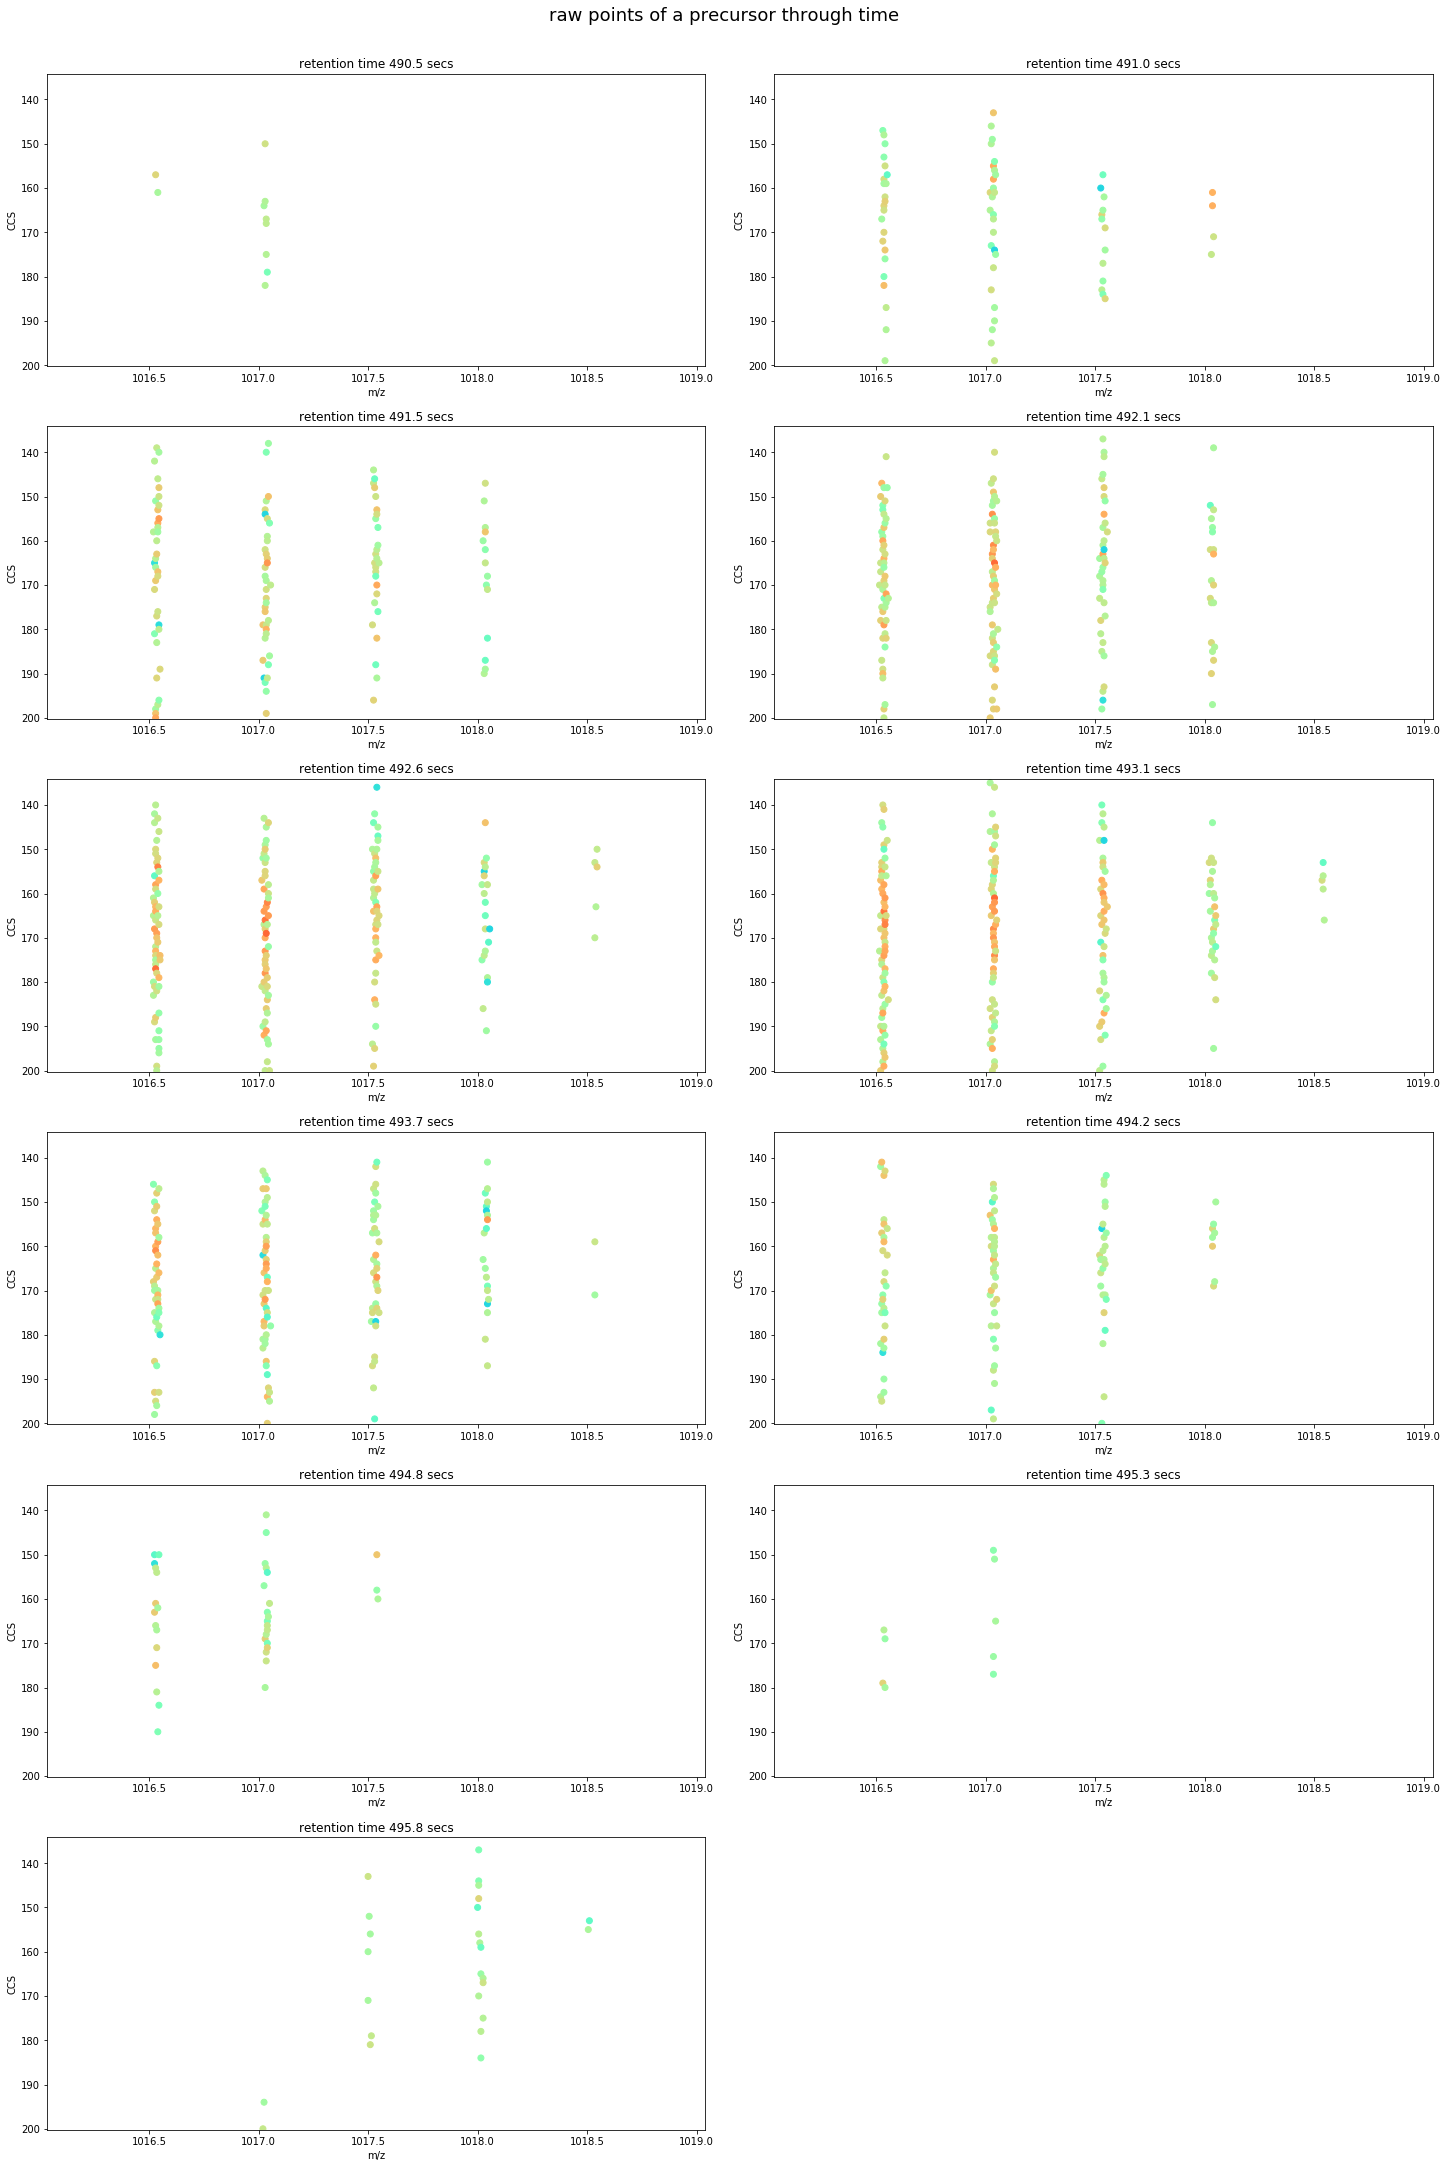

In [100]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(20)
f.suptitle('raw points of a precursor through time\n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(frames_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,frame_df in enumerate(frames_l):
    r = int(row_idx / 2)
    c = row_idx % 2
    ax = axarr[r,c]  # row, column

    retention_time = frame_df.iloc[0].retention_time_secs
    ax.set_title('retention time {} secs'.format(round(retention_time,1)))

    ax.scatter(frame_df.mz, frame_df.scan, c=frame_df.colour)

    # set up axes
    ax.set_xlim((mz_lower,mz_upper))
    ax.set_ylim((scan_upper,scan_lower))
    ax.set_xlabel('m/z')
    ax.set_ylabel('CCS')

plt.show()

#### make a tile series for the feature cuboid

In [123]:
def pixel_xy(mz, scan, mz_lower, mz_upper, scan_lower, scan_upper):
    x_pixels_per_mz = (PIXELS_X-1) / (mz_upper - mz_lower)
    y_pixels_per_scan = (PIXELS_Y-1) / (scan_upper - scan_lower)
    
    pixel_x = int((mz - mz_lower) * x_pixels_per_mz)
    pixel_y = int((scan - scan_lower) * y_pixels_per_scan)
    return (pixel_x, pixel_y)

In [124]:
mz_lower, mz_upper

(1016.0345127496565, 1019.0407798245932)

In [126]:
pixel_xy(mz_lower, scan_lower, mz_lower, mz_upper, scan_lower, scan_upper)

(0, 0)

In [103]:
pixel_df = pd.DataFrame(raw_df.apply(lambda row: pixel_xy(row.mz, row.scan, monoisotopic_mz-0.5, monoisotopic_mz+(10*0.5), scan_lower, scan_upper), axis=1).tolist(), columns=['pixel_x','pixel_y'])

In [104]:
raw_pixel_df = pd.concat([raw_df, pixel_df], axis=1)

In [105]:
# sum the intensity of raw points that have been assigned to each pixel
pixel_intensity_df = raw_pixel_df.groupby(by=['frame_id', 'pixel_x', 'pixel_y'], as_index=False).intensity.sum()

In [106]:
pixel_intensity_df.columns

Index(['frame_id', 'pixel_x', 'pixel_y', 'intensity'], dtype='object')

In [107]:
# calculate the colour to represent the intensity
colours_l = []
for i in pixel_intensity_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=True)[:3]))
colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
pixel_intensity_df = pd.merge(pixel_intensity_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

In [108]:
frames_l = []
for group_name,group_df in pixel_intensity_df.groupby(['frame_id'], as_index=False):
    frames_l.append(group_df)

In [109]:
# write out the images to files
for row_idx,frame_df in enumerate(frames_l):
    # create an intensity array
    tile_im_array = np.zeros([PIXELS_Y, PIXELS_X, 3], dtype=np.uint8)  # container for the image
    for r in zip(frame_df.pixel_x, frame_df.pixel_y, frame_df.colour):
        x = r[0]
        y = r[1]
        c = r[2]
        tile_im_array[y,x,:] = c

    # create an image of the intensity array
    tile = Image.fromarray(tile_im_array, 'RGB')
    tile_file_name = '{}/frame-{}.png'.format(ENCODED_FEATURES_DIR, row_idx+1)
    tile.save(tile_file_name)